### Train Gradient Booster Trees to estimate KPIS for vehicle routing problem

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sys

In [2]:
print('Python version used for this notebook is {}'.format(sys.version))

Python version used for this notebook is 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) 
[GCC 7.3.0]


#### Read data to data frame

In [3]:
# Load data
url = 'https://www.dropbox.com/s/2ifgkdu0lujpufz/deliverydata.ssv?dl=1'
data = pd.read_csv(url, sep=';')

#### Remove rows with NA entries 

In [4]:
data = data.dropna()

#### Calculate number of routes, number of deliveries, distance and time  per path and create new column for each. 

In [5]:
data['RouteCount'] = data.groupby('plan_id')['route_id'].transform(lambda x: x.nunique())

In [6]:
data['DeliveriesPerRoute'] = data.groupby(['plan_id','route_id'])['id'].transform(lambda x: x.nunique())

In [7]:
data['DistancePerRoute'] = data.groupby(['plan_id','route_id'])['dtn'].transform(sum)

In [8]:
data['TimePerRoute'] = data.groupby(['plan_id','route_id'])['ttn'].transform(sum)

#### Create new columns lon and lat from the WRT coordinates

In [9]:
def get_lon(input):
    return [float(s) for s in re.findall(r'-?\d+\.?\d*', input)][0]

In [10]:
def get_lat(input):
    return [float(s) for s in re.findall(r'-?\d+\.?\d*', input)][1]

In [11]:
data['lon']=data['coordinates'].apply(get_lon)

In [12]:
data['lat']=data['coordinates'].apply(get_lat)

#### Convert date column to datetime object

In [13]:
data['date'] =  pd.to_datetime(data['plan_date'])

#### Convert dates into week numbers

In [14]:
data['week_number'] = data['date'].dt.week

#### Create data frame data_uniq which have all duplicates of the combination of plan_id and route_id is dropped. Thus we are now at the route level of the data, which we will to compute the median KPIs.

In [15]:
data_uniq = data 

In [16]:
data_uniq = data_uniq.reset_index(drop=True)

In [17]:
data_uniq = data_uniq.drop_duplicates(subset=['plan_id','route_id'])

In [18]:
data_uniq = data_uniq.reset_index(drop=True)

In [19]:
data_uniq['medDistanceRoute'] = data_uniq.groupby('plan_id')['DistancePerRoute'].transform('median')

In [20]:
data_uniq['medDeliveriesRoute'] = data_uniq.groupby('plan_id')['DeliveriesPerRoute'].transform('median')

In [21]:
data_uniq['medTimePerRoute'] = data_uniq.groupby('plan_id')['TimePerRoute'].transform('median')

#### Create data set with only KPIs and predictors for visualization and correlation matrix computation

In [22]:
data_vis = data_uniq[['min_time','max_time','week_number','lat','lon','RouteCount','DeliveriesPerRoute','DistancePerRoute','TimePerRoute','medDistanceRoute','medDeliveriesRoute','medTimePerRoute']]

In [23]:
corr = data_vis.corr()

#### Visualize correlation matrix

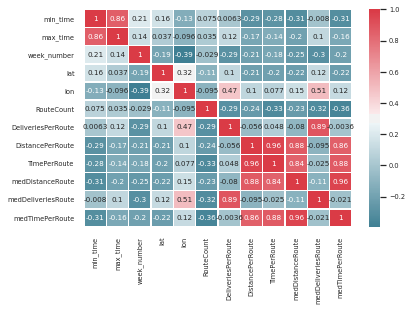

In [31]:
sns.set(font_scale=0.6)
sns.heatmap(corr, xticklabels=corr.columns,annot=True, yticklabels=corr.columns, linewidths=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.savefig('/home/mattias/Documents/CorrPlot.png')

### Plot distribution of predictors

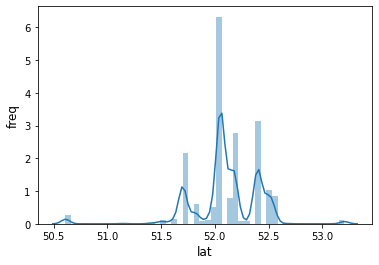

In [24]:
sns.distplot(data_vis['lat']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('lat',fontsize=12)
plt.savefig('/home/mattias/Documents/lat.png')

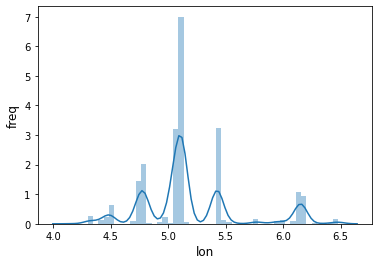

In [25]:
sns.distplot(data_vis['lon']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('lon',fontsize=12)
plt.savefig('/home/mattias/Documents/lon.png')

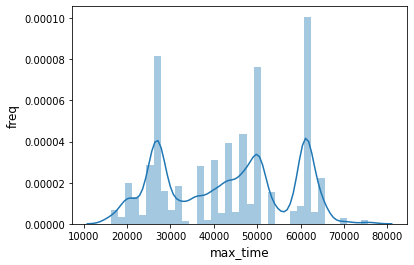

In [26]:
sns.distplot(data_vis['max_time']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('max_time',fontsize=12)
plt.savefig('/home/mattias/Documents/max_time.png')

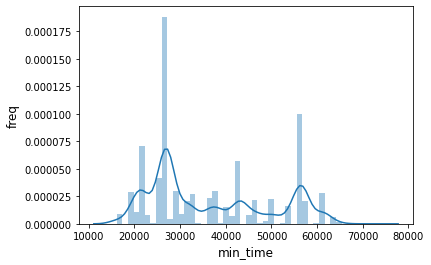

In [27]:
sns.distplot(data_vis['min_time']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('min_time',fontsize=12)
plt.savefig('/home/mattias/Documents/min_time.png')

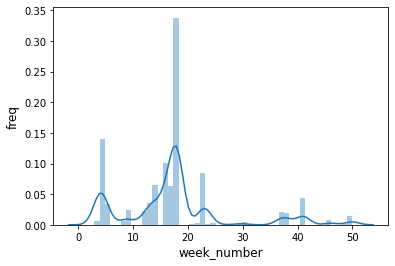

In [28]:
sns.distplot(data_vis['week_number']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('week_number',fontsize=12)
plt.savefig('/home/mattias/Documents/week_number.png')

#### Plot normalized histogram and fitted distribution for the KPIs and the raw count of each KPI (on which median is calculated). It is clear that all KPIs have a skew distribution. 

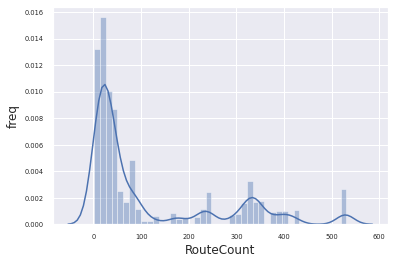

In [40]:
sns.distplot(data_vis['RouteCount']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('RouteCount',fontsize=12)
plt.savefig('/home/mattias/Documents/RouteCount.png')

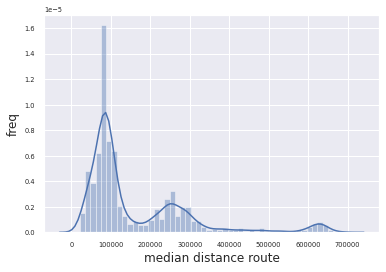

In [41]:
sns.distplot(data_vis['medDistanceRoute']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('median distance route',fontsize=12)
plt.savefig('/home/mattias/Documents/medDistanceRoute.png')

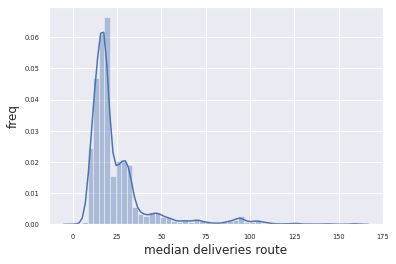

In [42]:
sns.distplot(data_vis['medDeliveriesRoute']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('median deliveries route',fontsize=12)
plt.savefig('/home/mattias/Documents/medDeliveriesRoute.png')

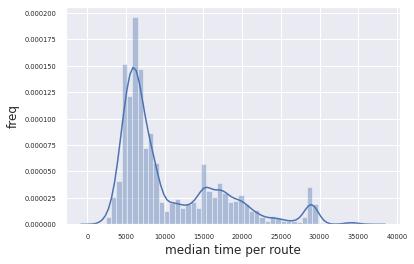

In [43]:
sns.distplot(data_vis['medTimePerRoute']);
plt.ylabel('freq',fontsize=12)
plt.xlabel('median time per route',fontsize=12)
plt.savefig('/home/mattias/Documents/medTimePerRoute.png')

##### Create dictonary for all median KPIs

In [44]:
data_uniq2 = data_uniq.drop_duplicates(subset=['plan_id'])

In [45]:
dataDictDeliv = data_uniq2[['plan_id','medDeliveriesRoute']]

In [46]:
DictDeliv = dict(dataDictDeliv.values.tolist())

In [47]:
dataDictDist = data_uniq2[['plan_id','medDistanceRoute']]

In [48]:
DictDist = dict(dataDictDist.values.tolist())

In [49]:
dataDictTime = data_uniq2[['plan_id','medTimePerRoute']]

In [50]:
DictTime = dict(dataDictTime.values.tolist())

##### Use dictonaries to map a KPI for each observation in data DataFrame.

In [51]:
data['medDeliveriesRoute'] = data['plan_id'].map(DictDeliv)

In [52]:
data['medDistanceRoute'] = data['plan_id'].map(DictDist)

In [53]:
data['medTimePerRoute'] = data['plan_id'].map(DictTime)

##### Drop columns in data before training

In [54]:
dataRandomF = data.drop(['plan_id','date','route_id','id','eta','ttn','dtn',
                         'TimePerRoute','DeliveriesPerRoute','DistancePerRoute'], axis=1)

#### Define train data X and targets y

In [55]:
X = dataRandomF[['min_time','max_time','lon','lat','week_number']]

In [56]:
X_w_coord = dataRandomF[['min_time','max_time','lon','lat','coordinates','plan_date','week_number']]

In [57]:
y_delivery = dataRandomF['medDeliveriesRoute']

In [58]:
y_distance = dataRandomF['medDistanceRoute']

In [59]:
y_time = dataRandomF['medTimePerRoute']

In [60]:
y_routeCnt = dataRandomF['RouteCount']

#### create Dmatrix for each combinations of training and test data

In [94]:
data_dmatrix_deliv = xgb.DMatrix(data=X,label=y_delivery)

In [95]:
data_dmatrix_dist = xgb.DMatrix(data=X,label=y_distance)

In [96]:
data_dmatrix_time = xgb.DMatrix(data=X,label=y_time)

In [97]:
data_dmatrix_routeCnt = xgb.DMatrix(data=X,label=y_routeCnt)

#### We set the number of boost rounds to 100. This is the same as the number of estimators in the XGBOOST model

In [69]:
num_boost_round = 100

#### Perform cross validation with 5 folds for each model. We choose to minimize the mean squared error in the objective, this is the reg:linear option.

In [98]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 11, 'alpha': 10,'silent':1}

cv_results_deliv = xgb.cv(dtrain=data_dmatrix_deliv, params=params, nfold=5,
                    num_boost_round=num_boost_round,early_stopping_rounds=10,metrics="rmse", 
                    as_pandas=True, seed=123)


In [99]:
range_y_deliv = np.max(y_delivery)-np.min(y_delivery)

In [100]:
test_rmse_mean_deliv = cv_results_deliv["test-rmse-mean"].tail(1)

In [101]:
norm_test_rmse_mean_deliv = test_rmse_mean_deliv/range_y_deliv
round_ntrmdeliv = round(float(norm_test_rmse_mean_deliv),2)

In [102]:
print('Using {} estimators, the normalized mean RMSE for deliveries is {}. Thus the prediction errors are {} percent of the range of data.'.format(num_boost_round,round_ntrmdeliv,100*round_ntrmdeliv))

Using 100 estimators, the normalized mean RMSE for deliveries is 0.09. Thus the prediction errors are 9.0 percent of the range of data.


In [103]:
cv_results_dist = xgb.cv(dtrain=data_dmatrix_dist, params=params, nfold=5,
                    num_boost_round=num_boost_round,early_stopping_rounds=10,metrics="rmse",
                         as_pandas=True, seed=123,verbose_eval=0)


In [104]:
range_y_dist = np.max(y_distance)-np.min(y_distance)

In [105]:
test_rmse_mean_dist = cv_results_dist["test-rmse-mean"].tail(1)

In [106]:
norm_test_rmse_mean_dist = test_rmse_mean_dist/range_y_dist
round_ntrmdist = round(float(norm_test_rmse_mean_dist),2)

In [107]:
print('Using {} estimators, the normalized mean RMSE for distance is {}. Thus the prediction errors are {} percent of the range of data.'.format(num_boost_round,round_ntrmdist,100*round_ntrmdist))

Using 100 estimators, the normalized mean RMSE for distance is 0.1. Thus the prediction errors are 10.0 percent of the range of data.


In [108]:
cv_results_time = xgb.cv(dtrain=data_dmatrix_time, params=params, nfold=5,
                    num_boost_round=num_boost_round,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


In [109]:
range_y_time = np.max(y_time)-np.min(y_time)

In [110]:
test_rmse_mean_time = cv_results_time["test-rmse-mean"].tail(1)

In [111]:
norm_test_rmse_mean_time = test_rmse_mean_time/range_y_time
round_ntrmtime = round(float(norm_test_rmse_mean_time),2)

In [112]:
print('Using {} estimators, the normalized mean RMSE for time is {}. Thus the prediction errors are {} percent of the range of data.'.format(num_boost_round,round_ntrmtime,100*round_ntrmtime))

Using 100 estimators, the normalized mean RMSE for time is 0.09. Thus the prediction errors are 9.0 percent of the range of data.


In [113]:
cv_results_routeCnt = xgb.cv(dtrain=data_dmatrix_routeCnt, params=params, nfold=5,
                    num_boost_round=num_boost_round,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


In [114]:
range_y_cnt = np.max(y_routeCnt)-np.min(y_routeCnt)

In [115]:
test_rmse_mean_cnt = cv_results_routeCnt["test-rmse-mean"].tail(1)

In [116]:
norm_test_rmse_mean_cnt = test_rmse_mean_cnt/range_y_cnt
round_ntrmcnt = round(float(norm_test_rmse_mean_cnt),2)

In [117]:
print('Using {} estimators, the normalized mean RMSE for route count per path is {}. Thus the prediction errors are {} percent of the range of data.'.format(num_boost_round,round_ntrmcnt,100*round_ntrmcnt))

Using 100 estimators, the normalized mean RMSE for route count per path is 0.14. Thus the prediction errors are 14.000000000000002 percent of the range of data.


#### In order to create our predictors with num_estimators = 100, which we learned was a proper setting from cross-validaton, we first do test train splits of the data.

In [61]:
X_train_deliv, X_test_deliv, y_train_deliv, y_test_deliv = train_test_split(X_w_coord, y_delivery, test_size=0.2, random_state=123)

In [120]:
X_train_dist, X_test_dist, y_train_dist, y_test_dist = train_test_split(X_w_coord, y_distance, test_size=0.2, random_state=123)

In [63]:
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(X_w_coord, y_time, test_size=0.2, random_state=123)

In [64]:
X_train_cnt, X_test_cnt, y_train_cnt, y_test_cnt = train_test_split(X_w_coord, y_routeCnt, test_size=0.2, random_state=123)

#### Create xgboost models and plot feature importances. Note that for route count we necessarily need to round our result, as we are looking for a discrete number (this is an approximation). The other KPIs are rounded accorded to convenience.

In [65]:
xg_reg_deliv = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 11, alpha = 10, n_estimators = num_boost_round)

#### In training we do use the 'coordinate' column, this is represented by lon and lat

In [66]:
xg_reg_deliv.fit(X_train_deliv[['min_time','max_time','lon','lat','week_number']],y_train_deliv)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

#### Visualize which features are the most important for median number of deliveries per path

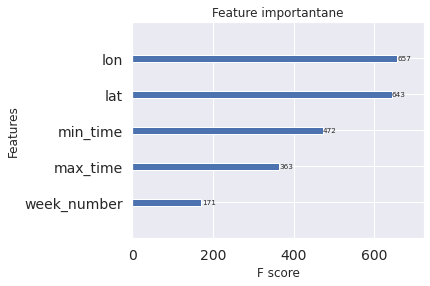

In [67]:
# plot feature importance
from xgboost import plot_importance
plot_importance(xg_reg_deliv)
plt.ylabel('Features',fontsize=12)
plt.xlabel('F score',fontsize=12)
plt.title('Feature importantane',fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('/home/mattias/Documents/featureImpDeliv.png')

In [70]:
xg_reg_dist = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 11, alpha = 10, n_estimators = num_boost_round)

#### In training we do use the 'coordinate' column, this is represented by lon and lat

In [71]:
xg_reg_dist.fit(X_train_dist[['min_time','max_time','lon','lat','week_number']],y_train_dist)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

#### Visualize which features are the most important for median distance per path

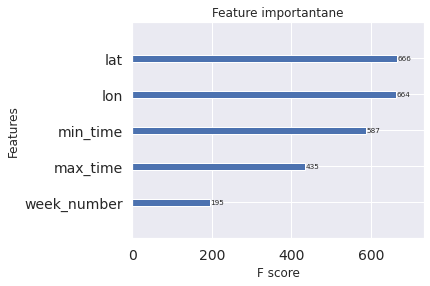

In [72]:
# plot feature importance
from xgboost import plot_importance
plot_importance(xg_reg_dist)
plt.ylabel('Features',fontsize=12)
plt.xlabel('F score',fontsize=12)
plt.title('Feature importantane',fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('/home/mattias/Documents/featureImpDist.png')

In [73]:
xg_reg_time = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 11, alpha = 10, n_estimators = num_boost_round)

#### In training we do use the 'coordinate' column, this is represented by lon and lat

In [74]:
xg_reg_time.fit(X_train_time[['min_time','max_time','lon','lat','week_number']],y_train_time)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

#### Visualize which features are the most important for median time per path

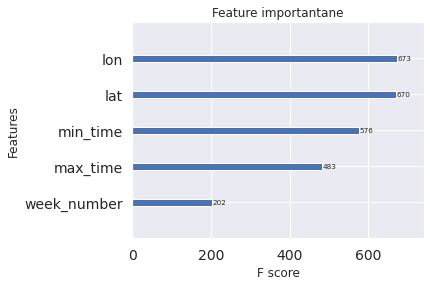

In [75]:
# plot feature importance
from xgboost import plot_importance
plot_importance(xg_reg_time)
plt.ylabel('Features',fontsize=12)
plt.xlabel('F score',fontsize=12)
plt.title('Feature importantane',fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('/home/mattias/Documents/featureImpTime.png')

In [76]:
xg_reg_cnt = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 11, alpha = 10, n_estimators = num_boost_round)

#### In training we do use the 'coordinate' column, this is represented by lon and lat

In [77]:
xg_reg_cnt.fit(X_train_cnt[['min_time','max_time','lon','lat','week_number']],y_train_cnt)


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

#### Visualize which features are the most important for number of routes per path

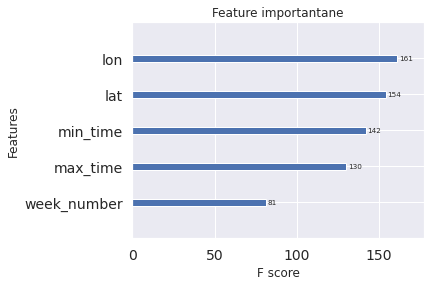

In [78]:
# plot feature importance
from xgboost import plot_importance
plot_importance(xg_reg_cnt)
plt.ylabel('Features',fontsize=12)
plt.xlabel('F score',fontsize=12)
plt.title('Feature importantane',fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('/home/mattias/Documents/featureImpCount.png')

#### Create predictors from trained models. Note that for route count we necessarily need to round our result, as we are looking for a discrete number (this is an approximation). The other KPIs are rounded accorded to convenience.

In [79]:
def predictKPIs(input,model,num_decimals):
    
    def get_lon(wkt_point):
        return [float(s) for s in re.findall(r'-?\d+\.?\d*', wkt_point)][0]
    
    def get_lat(wkt_point):
        return [float(s) for s in re.findall(r'-?\d+\.?\d*', wkt_point)][1]
    
    input = input[['min_time','max_time','coordinates','plan_date']]
    input = input.reset_index(drop=True)
    input['lon']=input['coordinates'].apply(get_lon)
    input['lat']=input['coordinates'].apply(get_lat)
    input['date'] =  pd.to_datetime(input['plan_date'])
    input['week_number'] = input['date'].dt.week
    
    input = input[['min_time','max_time','lon','lat','week_number']]
    
    pred = np.round(model.predict(input),num_decimals)

    return pred

##### Test prediction of KPIs with inputs min_time, max_time, coordinates,plan_date

In [80]:
test_df = X_test_cnt[['min_time','max_time','coordinates','plan_date']]
pred_test = predictKPIs(test_df,xg_reg_cnt,0)

#### Plot normalized histogram with fitted dist

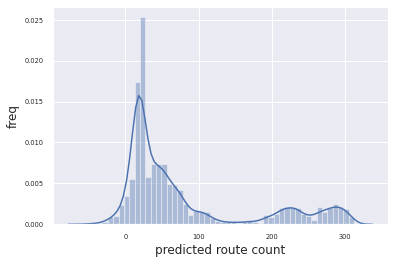

In [81]:
sns.distplot(pred_test);
plt.ylabel('freq',fontsize=12)
plt.xlabel('predicted route count',fontsize=12)
plt.savefig('/home/mattias/Documents/predCnt.png')

In [134]:
test_df = X_test_time[['min_time','max_time','coordinates','plan_date']]
pred_test = predictKPIs(test_df,xg_reg_time,0)

#### Plot normalized histogram with fitted dist

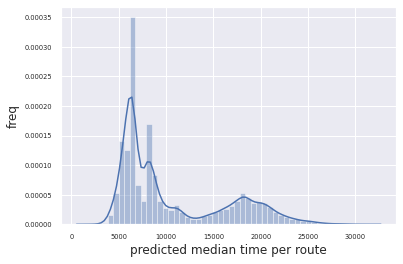

In [135]:
sns.distplot(pred_test);
plt.ylabel('freq',fontsize=12)
plt.xlabel('predicted median time per route',fontsize=12)
plt.savefig('/home/mattias/Documents/PredTimePerRoute.png')

In [132]:
test_df = X_test_dist[['min_time','max_time','coordinates','plan_date']]
pred_test = predictKPIs(test_df,xg_reg_dist,0)

#### Plot normalized histogram with fitted dist

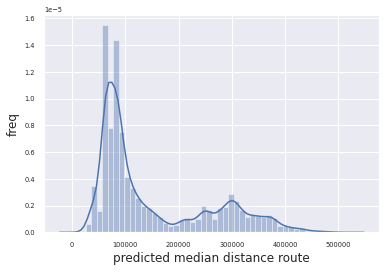

In [133]:
sns.distplot(pred_test);
plt.ylabel('freq',fontsize=12)
plt.xlabel('predicted median distance route',fontsize=12)
plt.savefig('/home/mattias/Documents/PredDistancePerRoute.png')

In [136]:
test_df = X_test_deliv[['min_time','max_time','coordinates','plan_date']]
pred_test = predictKPIs(test_df,xg_reg_deliv,2)

#### Plot normalized histogram with fitted dist

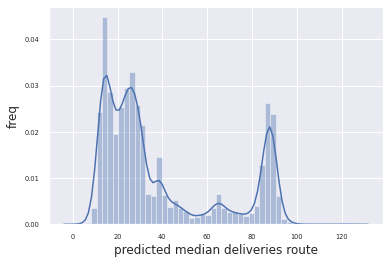

In [137]:
sns.distplot(pred_test);
plt.ylabel('freq',fontsize=12)
plt.xlabel('predicted median deliveries route',fontsize=12)
plt.savefig('/home/mattias/Documents/PredDeliveryPerRoute.png')